In [2]:
import torch
import os

os.chdir(r"C:\Users\cunn2\OneDrive\DSML\Project\thesis-repo")

rel_baseline_100k = torch.load(r"sms/exp2/results/rel_baseline_100k_results.pt")
rel_baseline_10k = torch.load(r"sms/exp2/results/rel_baseline_10k_results.pt")

C:\Users\cunn2\AppData\Local\Temp\ipykernel_33248\103963619.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rel_baseline_100k = torch.load(r"sms/exp2/results/rel_baselin

In [4]:
def print_nested_keys(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            print_nested_keys(value, indent + 1)
        else:
            print('  ' * (indent + 1) + f"Type: {type(value)}")

In [5]:
print_nested_keys(rel_baseline_100k)


model
  Type: <class 'str'>
dataset_size
  Type: <class 'str'>
index_type
  Type: <class 'str'>
index_params
  args
    Type: <class 'list'>
  kwargs
metrics
  chunk_transposed
    top_k
      100
        recall
          Type: <class 'list'>
        avg_recall
          Type: <class 'numpy.float64'>
      200
        recall
          Type: <class 'list'>
        avg_recall
          Type: <class 'numpy.float64'>
      500
        recall
          Type: <class 'list'>
        avg_recall
          Type: <class 'numpy.float64'>
      1000
        recall
          Type: <class 'list'>
        avg_recall
          Type: <class 'numpy.float64'>
      2500
        recall
          Type: <class 'list'>
        avg_recall
          Type: <class 'numpy.float64'>
      5000
        recall
          Type: <class 'list'>
        avg_recall
          Type: <class 'numpy.float64'>
    radius
      dataset_proportion_in_radius
        Type: <class 'list'>
      avg_dataset_proportion_in_radius
      

C:\Users\cunn2\AppData\Local\Temp\ipykernel_33248\2904911463.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location='cpu')
C:\Users\c

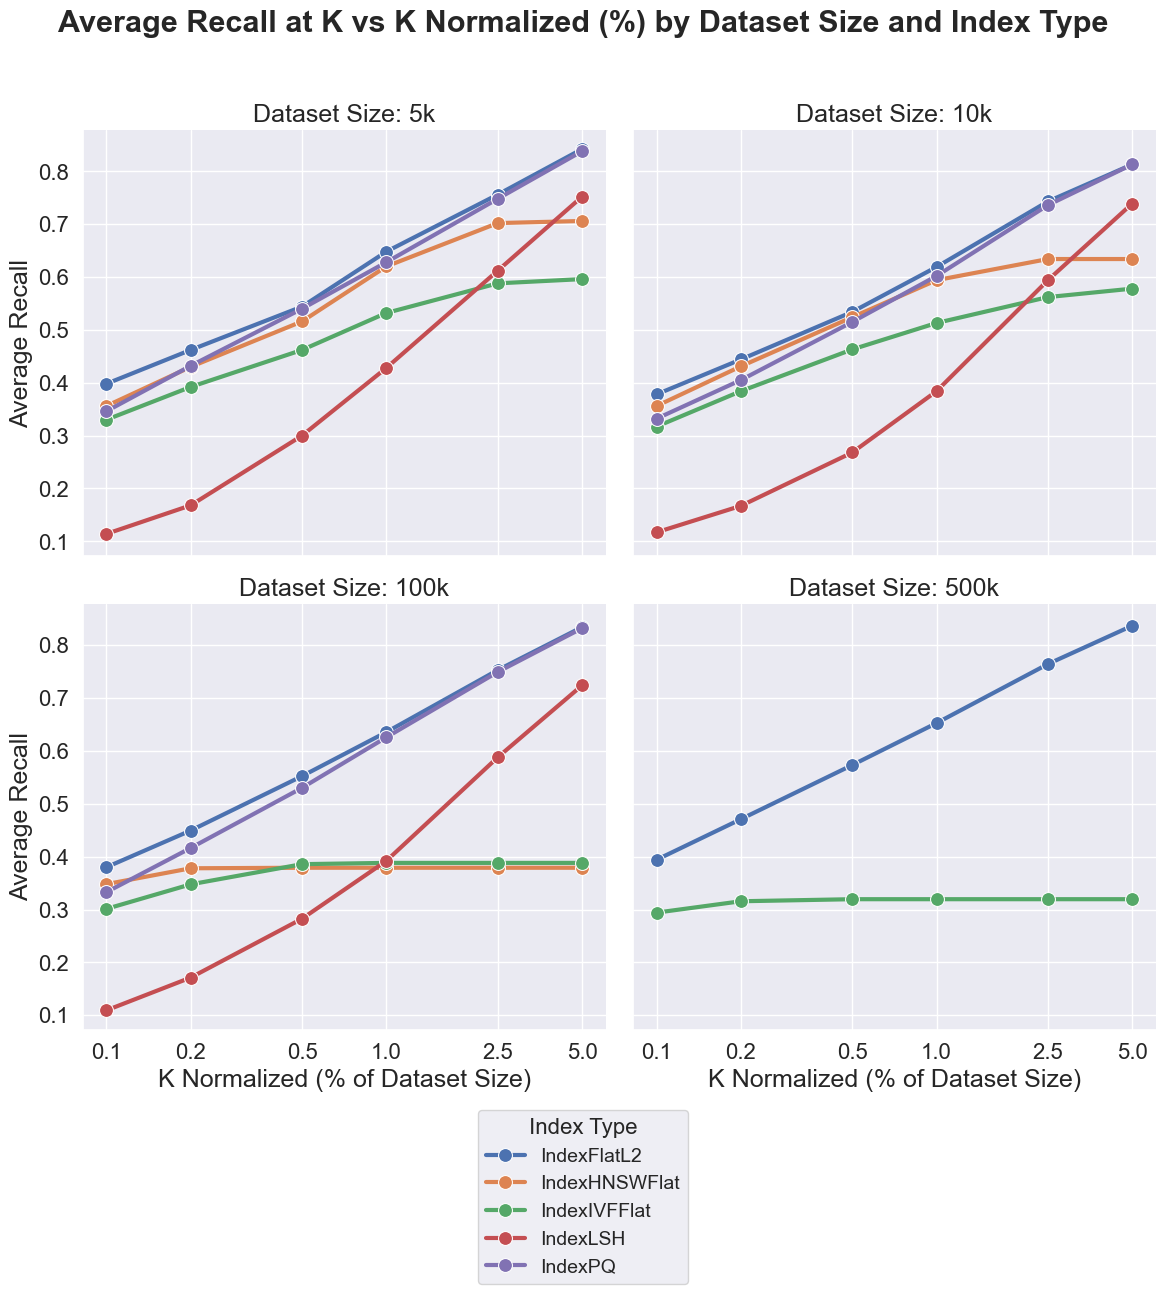

In [54]:
import torch
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from matplotlib import ticker

def parse_dataset_size(size_str):
    """
    Converts dataset size string like '100k', '10k', '1M' to integer.
    """
    size_str = size_str.lower().replace(',', '').strip()
    multipliers = {'k': 1_000, 'm': 1_000_000, 'b': 1_000_000_000}
    for suffix, multiplier in multipliers.items():
        if size_str.endswith(suffix):
            try:
                return int(float(size_str[:-1]) * multiplier)
            except ValueError:
                return None
    # If no suffix, attempt to convert directly
    try:
        return int(size_str)
    except ValueError:
        return None

def load_all_results(results_dir):
    """
    Loads all .pt result files from the specified directory.

    Args:
        results_dir (str): Path to the results directory.

    Returns:
        pd.DataFrame: Combined DataFrame with all relevant data.
    """
    records = []
    
    # Use glob to find all .pt files recursively
    pt_files = glob.glob(os.path.join(results_dir, '**', '*.pt'), recursive=True)
    
    for file_path in pt_files:
        try:
            data = torch.load(file_path, map_location='cpu')
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
        
        model = data.get('model', 'Unknown')
        dataset_size_str = data.get('dataset_size', 'Unknown')
        index_type = data.get('index_type', 'Unknown')
        
        dataset_size = parse_dataset_size(dataset_size_str)
        if dataset_size is None:
            print(f"Invalid dataset size format in {file_path}: '{dataset_size_str}'")
            continue
        
        metrics = data.get('metrics', {})
        
        for augmentation_name, augmentation_metrics in metrics.items():
            if not isinstance(augmentation_metrics, dict):
                continue
            
            if augmentation_name == 'query_times':
                top_k_metrics = augmentation_metrics.get('top_k', {})
                for k, qt_metrics in top_k_metrics.items():
                    try:
                        k = int(k)
                    except ValueError:
                        print(f"Invalid Top K value in query_times in {file_path}: '{k}'")
                        continue
                    
                    average = qt_metrics.get('average', None)
                    minimum = qt_metrics.get('minimum', None)
                    maximum = qt_metrics.get('maximum', None)
                    median = qt_metrics.get('median', None)
                    
                    if dataset_size > 0:
                        top_k_normalized = k / dataset_size
                        records.append({
                            'Model': model,
                            'Index Type': index_type,
                            'Dataset Size': dataset_size,
                            'Augmentation': 'Query Times',
                            'K': k,
                            'K Normalized': top_k_normalized,
                            'Average Recall': np.nan,
                            'Query Time Average': average,
                            'Query Time Minimum': minimum,
                            'Query Time Maximum': maximum,
                            'Query Time Median': median
                        })
            else:
                top_k_metrics = augmentation_metrics.get('top_k', {})
                for k, k_metrics in top_k_metrics.items():
                    try:
                        k = int(k)
                    except ValueError:
                        print(f"Invalid Top K value in {file_path}: '{k}'")
                        continue
                    
                    avg_recall = k_metrics.get('avg_recall', None)
                    if avg_recall is not None and dataset_size > 0:
                        top_k_normalized = k / dataset_size  # Normalize Top K
                        records.append({
                            'Model': model,
                            'Index Type': index_type,
                            'Dataset Size': dataset_size,
                            'Augmentation': augmentation_name,
                            'K': k,
                            'K Normalized': top_k_normalized,
                            'Average Recall': avg_recall
                        })
    
    df = pd.DataFrame(records)
    return df

def visualize_average_recall(df):
    """
    Creates a 2x2 grid of line plots showing Average Recall vs K Normalized (%), separated by Dataset Size.

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot.
    """
    # Filter out query times and other non-recall data
    recall_df = df.dropna(subset=['Average Recall'])
    
    # Mapping augmentation names for clarity
    aug_type_mapping = {
        'chunk_transposed': 'Transposition',
        'chunk_one_pitch_shifted': 'Single Note Pitch Shifted',
        'chunk_note_duration_changed': 'Single Note Duration Changed',
        'chunk_note_deleted': 'Single Note Deleted',
        'chunk_note_inserted': 'Single Note Inserted',
        'Average': 'Average'
    }
    recall_df['Augmentation'] = recall_df['Augmentation'].map(aug_type_mapping).fillna(recall_df['Augmentation'])
    
    # Clean up Index Type names
    recall_df['Index Type'] = recall_df['Index Type'].str.replace(r'_\d+$', '', regex=True)
    recall_df['Index Type'] = recall_df['Index Type'].str.replace(r'_', '', regex=True)
    
    # Convert K Normalized to percentage
    recall_df['K Normalized (%)'] = recall_df['K Normalized'] * 100
    
    # Divide Dataset Size by 1000
    recall_df['Dataset Size'] = recall_df['Dataset Size'] / 1000
    
    # Set plot style and increase font scale
    sns.set(style="darkgrid", font_scale=1.5)
    
    # Create FacetGrid with 2x2 layout
    g = sns.FacetGrid(recall_df, col="Dataset Size", hue="Index Type", height=6, aspect=1, col_wrap=2, sharey=True)
    g = g.map(sns.lineplot, "K Normalized (%)", "Average Recall", marker="o", ci=None, linewidth=3, markersize=10)  # Increased markersize from default to 10
    
    # Adjust scales and labels
    g.set_titles(template="Dataset Size: {col_name:.0f}k", fontsize=16)
    g.set(xscale='log')
    g.set_axis_labels("K Normalized (% of Dataset Size)", "Average Recall", fontsize=18)  # Increased font size
    g.fig.suptitle('Average Recall at K vs K Normalized (%) by Dataset Size and Index Type', fontsize=22, y=1.02, weight='bold')
    
    # Format x-axis ticks to show decimal values instead of scientific notation
    for ax in g.axes.flat:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.1f}"))
        
        # Get unique x values and set them as ticks
        x_values = sorted(recall_df['K Normalized (%)'].unique())
        ax.set_xticks(x_values)
        ax.set_xticklabels([f"{x:.1f}" for x in x_values], fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
    
    # Move legend below the plots and adjust number of columns
    unique_index_types = sorted(recall_df['Index Type'].unique())
    g.fig.legend(title="Index Type", loc='lower center', 
                 bbox_to_anchor=(0.5, -0.05), fontsize=14, title_fontsize=16, 
                 labels=unique_index_types)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.17, top=0.92)  # Adjust bottom to make room for legend and top for title
    plt.show()

RESULTS_DIR = "sms/exp2/qrb_best_results/"
df = load_all_results(RESULTS_DIR)

# Visualize Average Recall
visualize_average_recall(df)

In [68]:
def create_latex_table(df):
    # Filter and prepare data
    recall_df = df.dropna(subset=['Average Recall'])
    recall_df['K Normalized (%)'] = recall_df['K Normalized'] * 100
    recall_df['Dataset Size'] = recall_df['Dataset Size'] / 1000
    
    # Unique values
    dataset_sizes = sorted(recall_df['Dataset Size'].unique())
    index_types = sorted(recall_df['Index Type'].unique())
    k_percentages = sorted(recall_df['K Normalized (%)'].unique())
    
    # Start LaTeX table
    latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|l|" + "c|" * len(k_percentages) + "}\n\\hline\n"
    latex_table += "Index Type & " + " & ".join([f"{k:.1f}\\%" for k in k_percentages]) + " \\\\\n\\hline\\hline\n"
    
    for size in dataset_sizes:
        latex_table += f"\\multicolumn{{{len(k_percentages)+1}}}{{|c|}}{{Dataset Size: {size:.0f}k}} \\\\\n\\hline\n"
        for index in index_types:
            row_data = recall_df[(recall_df['Dataset Size'] == size) & (recall_df['Index Type'] == index)]
            if not row_data.empty:
                latex_table += f"{index} & "
                latex_table += " & ".join([f"{row_data[row_data['K Normalized (%)'] == k]['Average Recall'].values[0]:.3f}" if not row_data[row_data['K Normalized (%)'] == k].empty else "NA" for k in k_percentages])
                latex_table += " \\\\\n\\hline\n"
    
    latex_table += "\\end{tabular}\n"
    latex_table += "\\caption{Average Recall at K (\\% of Dataset Size) by Dataset Size and Index Type}\n"
    latex_table += "\\label{tab:average_recall}\n\\end{table}"
    
    return latex_table

# Generate and print the LaTeX table
latex_table = create_latex_table(df)
print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
Index Type & 0.1\% & 0.2\% & 0.5\% & 1.0\% & 2.5\% & 5.0\% \\
\hline\hline
\multicolumn{7}{|c|}{Dataset Size: 5k} \\
\hline
IndexFlatL2 & 0.810 & 0.830 & 0.880 & 0.960 & 0.970 & 0.990 \\
\hline
IndexHNSWFlat & 0.740 & 0.820 & 0.860 & 0.930 & 0.960 & 0.960 \\
\hline
IndexIVFFlat & 0.650 & 0.710 & 0.760 & 0.830 & 0.840 & 0.840 \\
\hline
IndexLSH & 0.210 & 0.280 & 0.500 & 0.670 & 0.900 & 0.970 \\
\hline
IndexPQ & 0.670 & 0.820 & 0.880 & 0.950 & 0.970 & 0.990 \\
\hline
\multicolumn{7}{|c|}{Dataset Size: 10k} \\
\hline
IndexFlatL2 & 0.695 & 0.765 & 0.840 & 0.885 & 0.995 & 1.000 \\
\hline
IndexHNSWFlat & 0.680 & 0.755 & 0.830 & 0.860 & 0.880 & 0.880 \\
\hline
IndexIVFFlat & 0.600 & 0.660 & 0.725 & 0.750 & 0.805 & 0.805 \\
\hline
IndexLSH & 0.215 & 0.295 & 0.450 & 0.620 & 0.845 & 0.955 \\
\hline
IndexPQ & 0.635 & 0.735 & 0.805 & 0.870 & 0.990 & 1.000 \\
\hline
\multicolumn{7}{|c|}{Dataset Size: 100k} \\
\hline
IndexFlatL2 & 0

C:\Users\cunn2\AppData\Local\Temp\ipykernel_33248\350522179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recall_df['K Normalized (%)'] = recall_df['K Normalized'] * 100
C:\Users\cunn2\AppData\Local\Temp\ipykernel_33248\350522179.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recall_df['Dataset Size'] = recall_df['Dataset Size'] / 1000


In [69]:
def create_latex_table(df):
    # Filter and prepare data
    recall_df = df.dropna(subset=['Average Recall']).copy()
    
    # Clean up Index Type names
    recall_df['Index Type'] = recall_df['Index Type'].str.replace(r'_\d+$', '', regex=True)
    recall_df['Index Type'] = recall_df['Index Type'].str.replace(r'_', '', regex=True)
    
    # Convert K Normalized to percentage
    recall_df['K Normalized (%)'] = recall_df['K Normalized'] * 100
    
    # Divide Dataset Size by 1000 and round to nearest integer
    recall_df['Dataset Size'] = np.round(recall_df['Dataset Size'] / 1000).astype(int)
    
    # Unique values
    dataset_sizes = sorted(recall_df['Dataset Size'].unique())
    index_types = sorted(recall_df['Index Type'].unique())
    k_percentages = sorted(recall_df['K Normalized (%)'].unique())
    
    # Start LaTeX table
    latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|l|" + "c|" * len(k_percentages) + "}\n\\hline\n"
    latex_table += "Index Type & " + " & ".join([f"{k:.1f}\\%" for k in k_percentages]) + " \\\\\n\\hline\\hline\n"
    
    for size in dataset_sizes:
        latex_table += f"\\multicolumn{{{len(k_percentages)+1}}}{{|c|}}{{Dataset Size: {size}k}} \\\\\n\\hline\n"
        for index in index_types:
            row_data = recall_df[(recall_df['Dataset Size'] == size) & (recall_df['Index Type'] == index)]
            if not row_data.empty:
                latex_table += f"{index} & "
                latex_table += " & ".join([f"{row_data[row_data['K Normalized (%)'] == k]['Average Recall'].mean():.3f}" if not row_data[row_data['K Normalized (%)'] == k].empty else "NA" for k in k_percentages])
                latex_table += " \\\\\n\\hline\n"
    
    latex_table += "\\end{tabular}\n"
    latex_table += "\\caption{Average Recall at K (\\% of Dataset Size) by Dataset Size and Index Type}\n"
    latex_table += "\\label{tab:average_recall}\n\\end{table}"
    
    return latex_table

# Generate and print the LaTeX table
latex_table = create_latex_table(df)
print(latex_table)

# Print unique dataset sizes to verify
print("\nUnique Dataset Sizes:")
print(df['Dataset Size'].unique())

\begin{table}[h]
\centering
\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
Index Type & 0.1\% & 0.2\% & 0.5\% & 1.0\% & 2.5\% & 5.0\% \\
\hline\hline
\multicolumn{7}{|c|}{Dataset Size: 5k} \\
\hline
IndexFlatL2 & 0.398 & 0.462 & 0.544 & 0.648 & 0.756 & 0.842 \\
\hline
IndexHNSWFlat & 0.356 & 0.430 & 0.516 & 0.620 & 0.702 & 0.706 \\
\hline
IndexIVFFlat & 0.330 & 0.392 & 0.462 & 0.532 & 0.588 & 0.596 \\
\hline
IndexLSH & 0.114 & 0.168 & 0.300 & 0.428 & 0.612 & 0.752 \\
\hline
IndexPQ & 0.346 & 0.432 & 0.540 & 0.628 & 0.748 & 0.838 \\
\hline
\multicolumn{7}{|c|}{Dataset Size: 10k} \\
\hline
IndexFlatL2 & 0.378 & 0.444 & 0.534 & 0.619 & 0.743 & 0.813 \\
\hline
IndexHNSWFlat & 0.356 & 0.431 & 0.524 & 0.594 & 0.634 & 0.634 \\
\hline
IndexIVFFlat & 0.317 & 0.384 & 0.463 & 0.513 & 0.562 & 0.578 \\
\hline
IndexLSH & 0.117 & 0.167 & 0.268 & 0.384 & 0.594 & 0.739 \\
\hline
IndexPQ & 0.332 & 0.405 & 0.515 & 0.602 & 0.736 & 0.813 \\
\hline
\multicolumn{7}{|c|}{Dataset Size: 100k} \\
\hline
IndexFlatL2 & 0

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

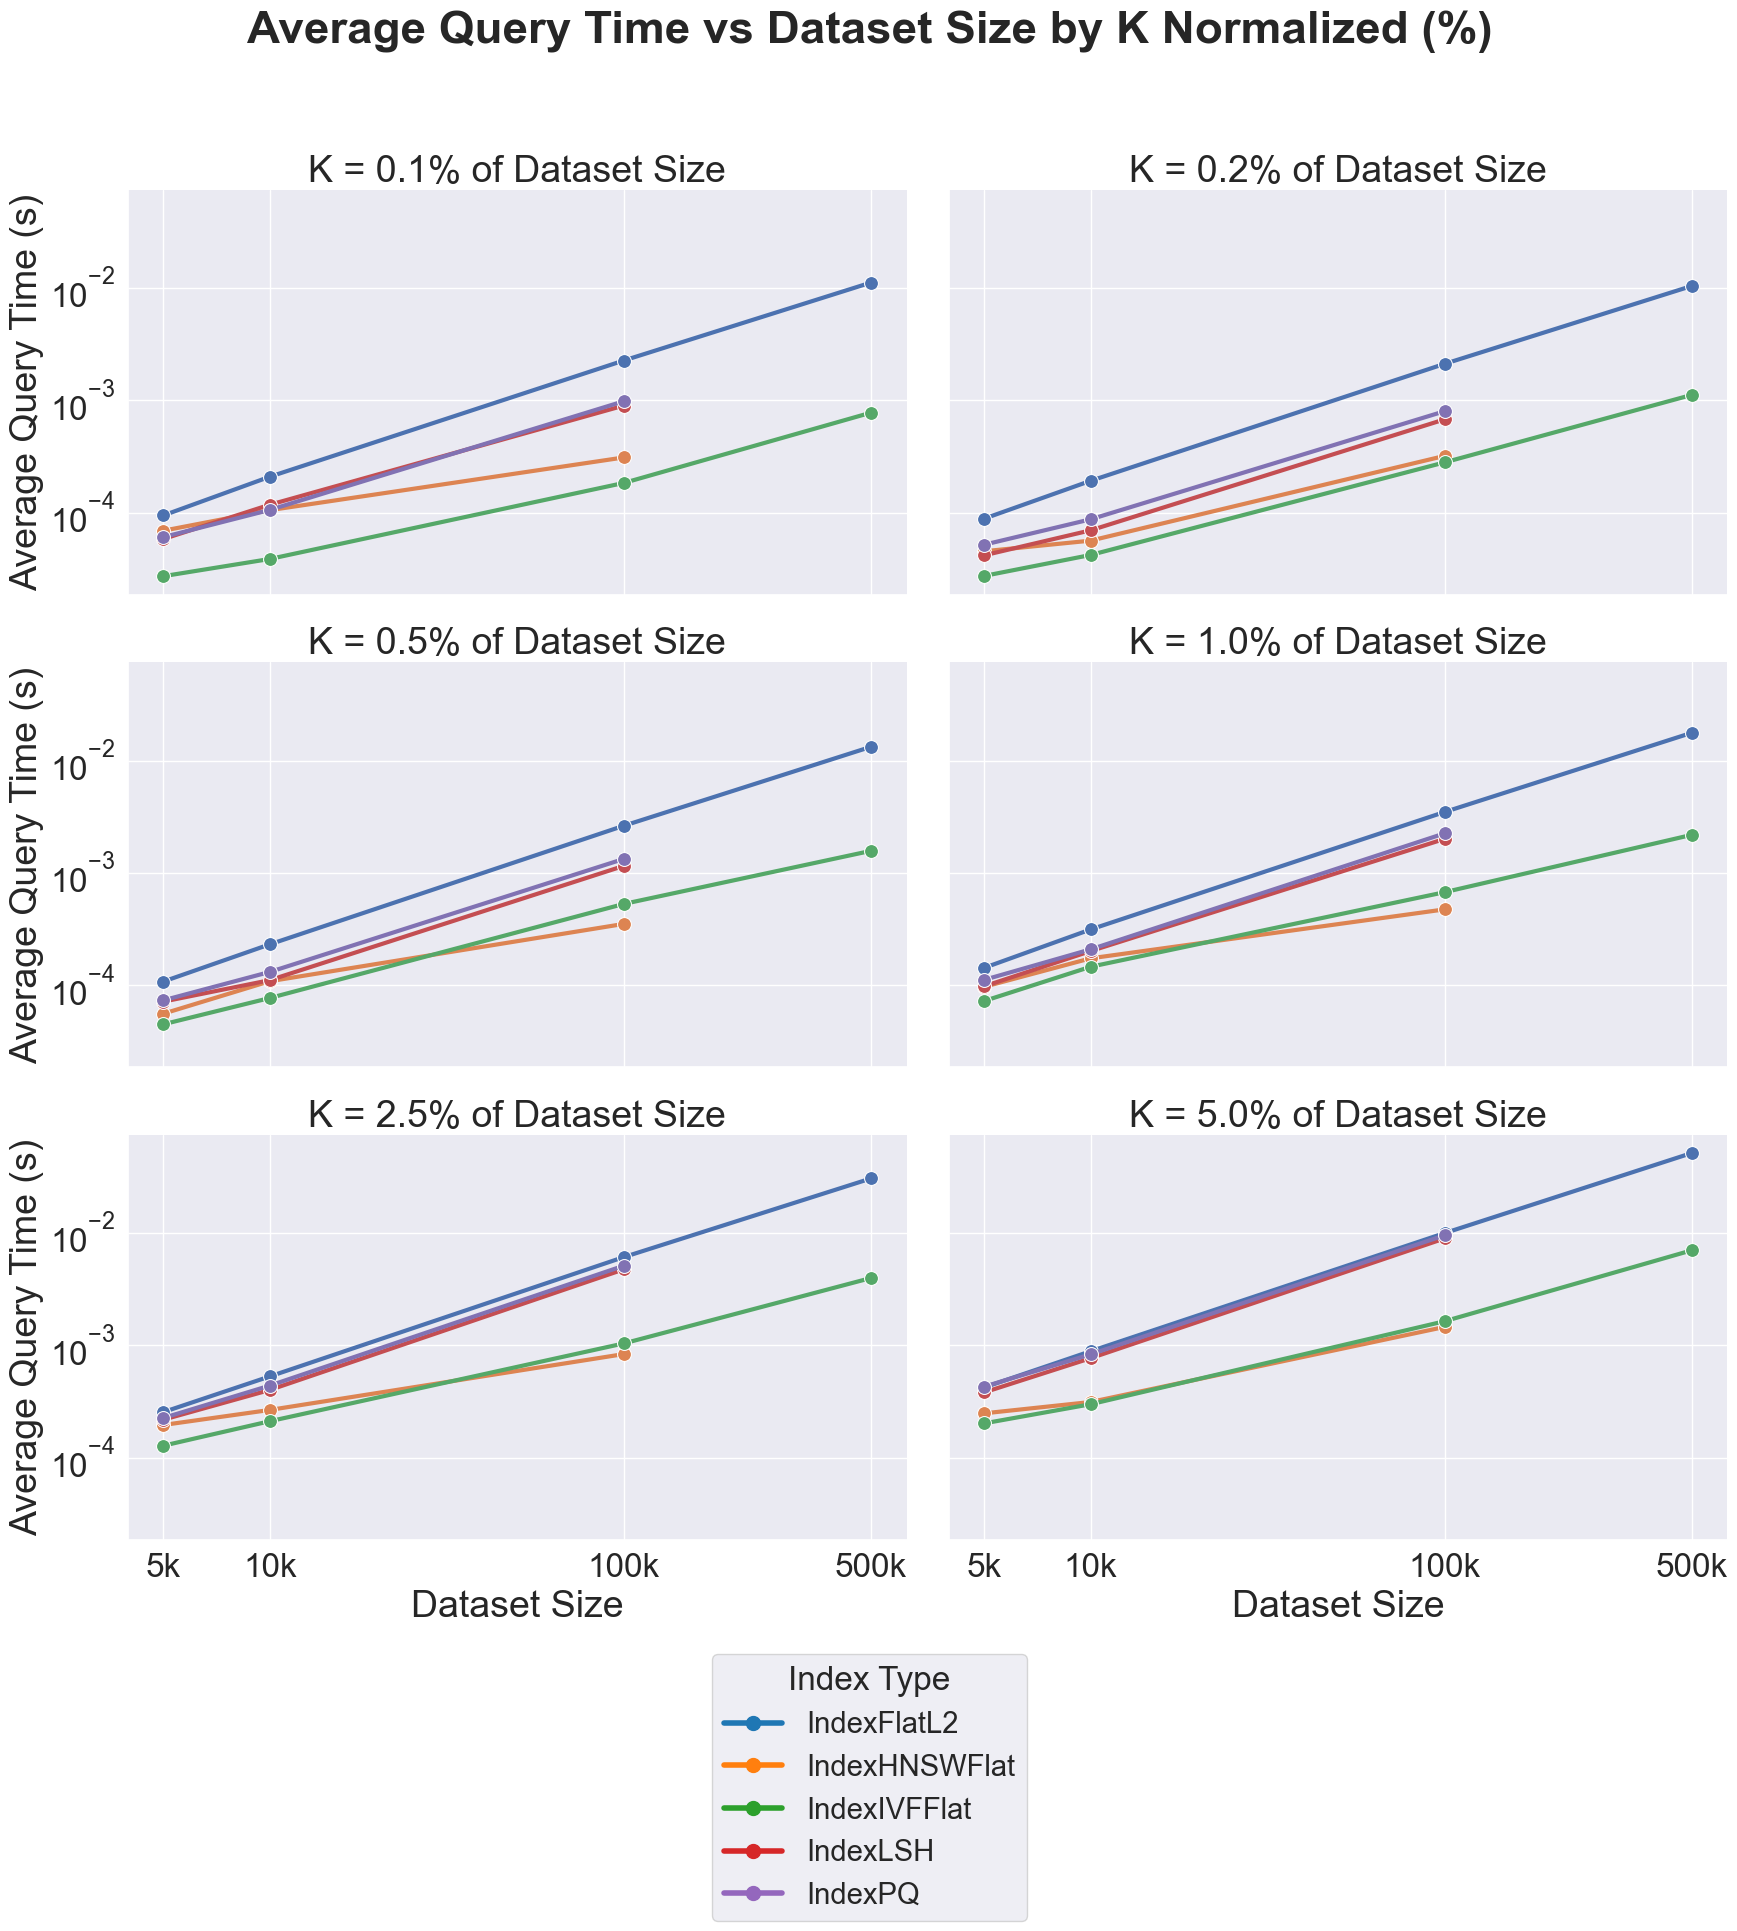

In [61]:
def visualize_query_times(df):
    """
    Creates a faceted line plot showing Query Time Average vs Dataset Size, separated by K Normalized (%).

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot.
    """
    # Filter out non-query time data
    qt_df = df[df['Augmentation'] == 'Query Times'].dropna(subset=['Query Time Average'])
    
    # Convert K Normalized to percentage
    qt_df['K Normalized (%)'] = qt_df['K Normalized'] * 100
    
    # Round K Normalized (%) to nearest value in the specified list
    k_percentages = [0.1, 0.2, 0.5, 1.0, 2.5, 5.0]
    qt_df['K Normalized (%) Rounded'] = qt_df['K Normalized (%)'].apply(lambda x: min(k_percentages, key=lambda k: abs(k-x)))
    
    # Set plot style and increase font scale
    sns.set(style="darkgrid", font_scale=2.25)
    
    # Create FacetGrid with 3x2 layout
    g = sns.FacetGrid(qt_df, col="K Normalized (%) Rounded", 
                      col_wrap=2, height=6, aspect=1.5, sharex=True, sharey=True)
    
    # Plot lines with both axes logarithmic, double line thickness and point sphere size
    g = g.map(sns.lineplot, "Dataset Size", "Query Time Average", "Index Type", marker="o", linewidth=3, markersize=10)
    
    # Set both axes to logarithmic scale
    g.set(xscale="log", yscale="log")
    
    # Adjust scales and labels
    g.set_titles(template="K = {col_name}% of Dataset Size", fontsize=24)
    g.set_axis_labels("Dataset Size", "Average Query Time (s)", fontsize=27)
    g.fig.suptitle('Average Query Time vs Dataset Size by K Normalized (%)', fontsize=33, y=1.02, weight='bold')
    
    # Format x-axis ticks
    for ax in g.axes.flat:
        dataset_sizes = sorted(qt_df['Dataset Size'].unique())
        ax.set_xticks(dataset_sizes)
        ax.set_xticklabels([f"{x/1000:.0f}k" if x >= 1000 else str(x) for x in dataset_sizes], fontsize=24)
        plt.setp(ax.xaxis.get_majorticklabels())
        ax.tick_params(axis='y', labelsize=24)
    
    # Create custom legend
    unique_index_types = sorted(qt_df['Index Type'].unique())
    custom_lines = [plt.Line2D([0], [0], color=plt.cm.tab10(i), lw=4, marker='o', markersize=10) 
                    for i in range(len(unique_index_types))]
    
    # Add the custom legend below the plots
    g.fig.legend(custom_lines, unique_index_types, title="Index Type", loc='lower center', 
                 bbox_to_anchor=(0.5, -0.05), fontsize=21, title_fontsize=24)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.17, top=0.92)
    plt.show()


# Visualize Query Times
visualize_query_times(df)

In [67]:
def create_query_times_latex_table(df):
    # Create a copy of the dataframe and filter for query times
    qt_df = df[df['Augmentation'] == 'Query Times'].dropna(subset=['Query Time Average']).copy()
    
    # Clean up Index Type names
    qt_df.loc[:, 'Index Type'] = qt_df['Index Type'].str.replace(r'_\d+$', '', regex=True)
    qt_df.loc[:, 'Index Type'] = qt_df['Index Type'].str.replace(r'_', '', regex=True)
    
    # Convert K Normalized to percentage
    qt_df.loc[:, 'K Normalized (%)'] = qt_df['K Normalized'] * 100
    
    # Divide Dataset Size by 1000 and round to nearest integer
    qt_df.loc[:, 'Dataset Size'] = np.round(qt_df['Dataset Size'] / 1000).astype(int)
    
    # Get unique values
    dataset_sizes = sorted(qt_df['Dataset Size'].unique())
    index_types = sorted(qt_df['Index Type'].unique())
    k_percentages = sorted(qt_df['K Normalized (%)'].unique())
    
    # Start LaTeX table
    latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{l|" + "r|" * (len(k_percentages) - 1) + "r}\n\\hline\n"
    latex_table += "Index Type & " + " & ".join([f"{k:.1f}\\%" for k in k_percentages]) + " \\\\\n\\hline\\hline\n"
    
    for size in dataset_sizes:
        latex_table += f"\\multicolumn{{{len(k_percentages)+1}}}{{c}}{{\\textbf{{Dataset Size: {size}k}}}} \\\\\n\\hline\n"
        for index in index_types:
            row_data = qt_df[(qt_df['Dataset Size'] == size) & (qt_df['Index Type'] == index)]
            if not row_data.empty:
                latex_table += f"{index} & "
                latex_table += " & ".join([f"{row_data[row_data['K Normalized (%)'] == k]['Query Time Average'].values[0]:.6f}" if not row_data[row_data['K Normalized (%)'] == k].empty else "NA" for k in k_percentages])
                latex_table += " \\\\\n"
        latex_table += "\\hline\n"
    
    latex_table += "\\end{tabular}\n"
    latex_table += "\\caption{Average Query Time (seconds) at K (\\% of Dataset Size) by Dataset Size and Index Type}\n"
    latex_table += "\\label{tab:average_query_time}\n\\end{table}"
    
    return latex_table

# Generate and print the LaTeX table for query times
RESULTS_DIR = "sms/exp2/qrb_best_results/"
df = load_all_results(RESULTS_DIR)
query_times_latex_table = create_query_times_latex_table(df)
print(query_times_latex_table)

\begin{table}[h]
\centering
\begin{tabular}{l|r|r|r|r|r|r}
\hline
Index Type & 0.1\% & 0.2\% & 0.5\% & 1.0\% & 2.5\% & 5.0\% \\
\hline\hline
\multicolumn{7}{c}{\textbf{Dataset Size: 5k}} \\
\hline
IndexFlatL2 & 0.000095 & 0.000089 & 0.000108 & 0.000143 & 0.000255 & 0.000423 \\
IndexHNSWFlat & 0.000069 & 0.000045 & 0.000056 & 0.000097 & 0.000196 & 0.000248 \\
IndexIVFFlat & 0.000027 & 0.000027 & 0.000045 & 0.000072 & 0.000128 & 0.000202 \\
IndexLSH & 0.000058 & 0.000042 & 0.000072 & 0.000098 & 0.000218 & 0.000382 \\
IndexPQ & 0.000061 & 0.000052 & 0.000073 & 0.000112 & 0.000226 & 0.000429 \\
\hline
\multicolumn{7}{c}{\textbf{Dataset Size: 10k}} \\
\hline
IndexFlatL2 & 0.000209 & 0.000193 & 0.000231 & 0.000314 & 0.000530 & 0.000888 \\
IndexHNSWFlat & 0.000106 & 0.000057 & 0.000109 & 0.000174 & 0.000266 & 0.000314 \\
IndexIVFFlat & 0.000039 & 0.000042 & 0.000077 & 0.000146 & 0.000212 & 0.000299 \\
IndexLSH & 0.000118 & 0.000070 & 0.000111 & 0.000202 & 0.000401 & 0.000770 \\
IndexPQ & 0.00

C:\Users\cunn2\AppData\Local\Temp\ipykernel_33248\2904911463.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location='cpu')
